

# Express the disk warp in terms of an azimuthal-harmonic basis 

We can use a naive formalism similar to calculating the Fourier $A_2$ amplitude of a bar (for the fundamental mode). For an azimuthally-harmonic basis, we only need the $m=1$ mode:

$$  z(R) = \frac{2}{\sum_j M_j} \left| \sum_j M_j z_j \exp(i m\theta_j) \right| $$

We can also recover the warp phase-angle: 

$$ \varphi(R) = \frac{1}{m}\arctan2\left(\frac{\sum_jM_jz_j \sin(m\theta_j)}{\sum_jM_jz_j \cos(m\theta_j)}\right) $$

Where the summation is carried out over all particles in some azimuthal bin.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size']=14
import agama
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")

In [2]:
class decomposeDisk:
    
    def __init__(self,coords,mass,bins,mmax=4):
        """
        Decompose the vertical structure of the disk into an Azimuthal-Harmonic basis set.
        Inputs:
                coords: Cartesian (x,y,z) positions of the disk particles, assumed to be 
                        centered and rotated such that the central angular momentum axis 
                        lies along z
                        
                mass:   Masses of each particle
                
                bins:   annular bins in which to perform the expansion
                
                mmax:   maximum m order of the expansion. Usually higher than 1 is not needed, 
                        and may be excessively noisy currently
                        
        Outputs: 
                None
        
        """
        # Convert to cylindrical
        self.R = np.sqrt(coords[:,0]**2+coords[:,1]**2)
        self.Theta = np.arctan2(coords[:,1],coords[:,0])
        self.Z = coords[:,2]
        self.mass = mass
        self.mmax = mmax
        
        # Set up loop through bins, run decomposition on each
        self.z_m_R = []
        self.bin_centers = []
        for i in range(len(bins)-1): 
            bin_indices = (self.R>bins[i])&(self.R<bins[i+1])
            self.z_m_R.append(self.decompose(bin_indices))
            self.bin_centers.append(np.sum(mass[bin_indices]*self.R[bin_indices])/np.sum(mass[bin_indices]))
        
        # Get the mag and phase angle of coefficients
        self.z_m_R = np.array(self.z_m_R)
        self.z_m_R_mag = np.real(np.sqrt(self.z_m_R*np.conj(self.z_m_R)))
        self.z_m_R_PA = 1/np.arange(mmax+1)*np.arctan2(np.imag(self.z_m_R),np.real(self.z_m_R))
        
        # mean particle position in each bin,
        self.bin_centers = np.array(self.bin_centers)
        self.z_m_Spl = CubicSpline(self.bin_centers,self.z_m_R)
        
    def decompose(self,indices):
        """
        Performs the decomposition into the basis set coefficient weights, 
        should only be used internally by __init__
        
        Inputs:
                indices: the indices into coords and mass to be considered in the decomposition
                
        Outputs:
                z_m_arr: the coefficient weights
        
        """
        z_m_arr = []
        for m in range(0,self.mmax+1,1):
            z_m = np.sum(self.mass[indices]*self.Z[indices]*np.exp(1j*m*self.Theta[indices])) /\
                    np.sum(self.mass[indices])
            if m != 0: z_m *= 2
            z_m_arr.append(z_m)
        return np.array(z_m_arr)        
        
    def reconstruct_disk(self,pos,m_inds=None):
        """
        Recover the model z-height above/below the nominal disk plane for selected m-modes
        Inputs: 
                pos:      array-like grid of points to return z-height along
                m_inds:   array-like or int, m-modes to use in model reconstruction
            
        Outputs:
                z_recov:  array of same shape as pos, the model z-value at pos
        """
        m_arr = np.arange(self.mmax+1)
        
        # Convert to cylindrical 
        R = np.sqrt(pos[:,0]**2+pos[:,1]**2)
        Theta = np.arctan2(pos[:,1],pos[:,0])
        
        # Get the interpolated coefficients
        z_m = self.z_m_Spl(R)
        
        # Recover phase angle and magnitude of coefficients
        z_phi = 1/m_arr * np.arctan2(np.imag(z_m),np.real(z_m))
        z_mag = np.real(np.sqrt(z_m*np.conj(z_m)))
        
        # Reconstruct z-profile, sum contribution from each m
        if m_inds is None:
            m_inds = m_arr
            
        z_recov_m = np.array([z_mag[:,m]*np.cos(m_arr[m]*(Theta-z_phi[:,m])) for m in m_arr])
        return np.nansum(z_recov_m[m_inds,:],axis=0)

# Toy model 
(Note this is quite unphysical)

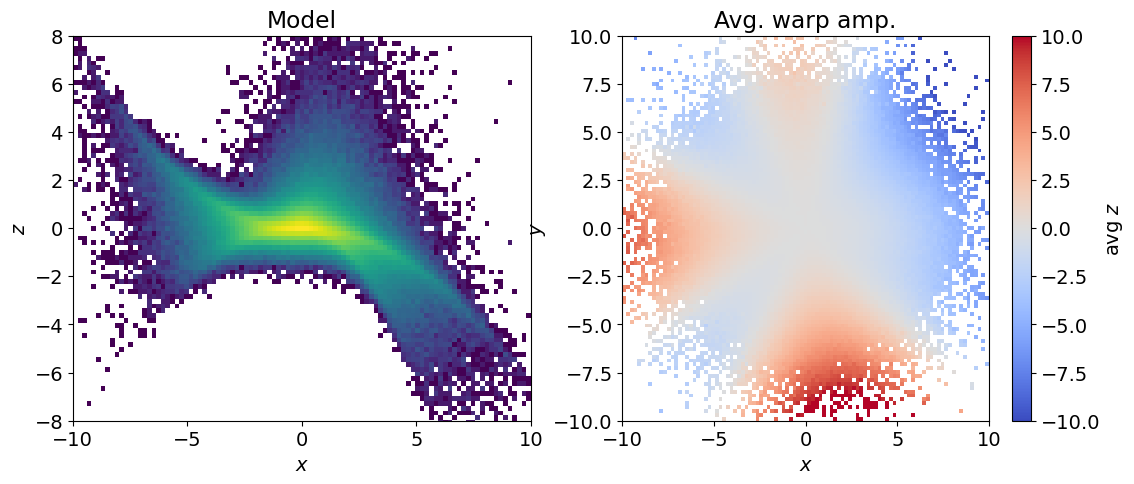

In [3]:
diskDen = agama.Density(type='Disk',scaleHeight=.2)
pos,mass = diskDen.sample(1000000)

##########################################
# Produce a warp with higher-order m terms

R = np.sqrt(pos[:,0]**2+pos[:,1]**2)
theta = np.arctan2(pos[:,1]/R,pos[:,0]/R)

# random phase angles for each mode
warp_pa = np.random.uniform(-np.pi,np.pi,5)
cos_terms = np.array([np.cos(m*(theta-warp_pa[m])) for m in range(0,5,1)])

mode_weights = np.array([0,1.5,1,.8,1])

warp_offsets = np.array([(R/5)**2*mode_weights[m]*cos_terms[m] for m in range(0,5,1)])
warp_offset = np.sum(warp_offsets,axis=0)

pos_warp = np.copy(pos)
pos_warp[:,2] = pos_warp[:,2] + warp_offset

###########################
# Visualize the model warp
x_bin = np.linspace(-10,10,100)
hist,_,_ = np.histogram2d(pos_warp[:,0],pos_warp[:,1],bins=x_bin,weights=pos_warp[:,2])
weights,_,_ = np.histogram2d(pos_warp[:,0],pos_warp[:,1],bins=x_bin)
warp_im,_,_ = np.histogram2d(pos_warp[:,0],pos_warp[:,2],bins=x_bin)
avg_offset = hist/weights


fig,axes = plt.subplots(1,2,figsize=(13,5))
im = axes[1].pcolormesh(x_bin,x_bin,avg_offset.T,cmap='coolwarm',vmax=10,vmin=-10)
plt.colorbar(im,label=r'avg $z$')
axes[0].pcolormesh(x_bin,x_bin,np.log10(warp_im).T)

axes[0].set_title('Model')
axes[1].set_title('Avg. warp amp.')

axes[0].set_ylim(-8,8)
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$z$')

axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$');

## Perform the expansion

In [4]:
# set up bins
logBins = np.logspace(-1,1,20)

# Perform the expansion
mmax=4
warpModel = decomposeDisk(pos_warp,mass,logBins,mmax=mmax)

## Recover expansion coefficients

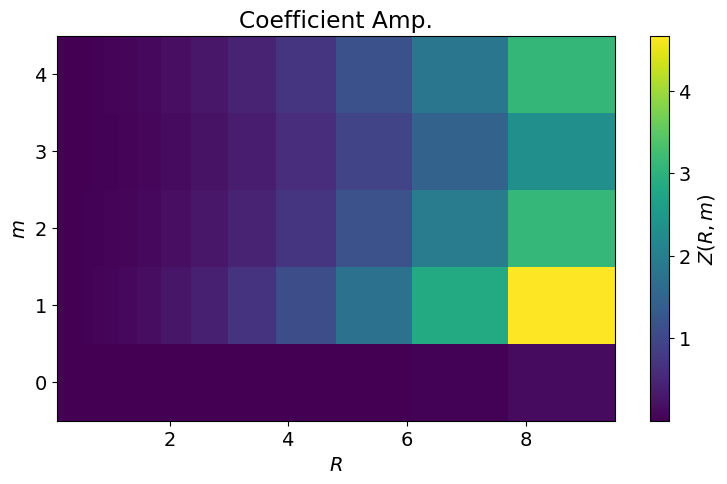

In [5]:
fig = plt.figure(figsize=(9,5))
im = plt.pcolormesh(warpModel.bin_centers,np.arange(5),
               warpModel.z_m_R_mag.T,
               shading='nearest')

plt.xlabel(r'$R$')
plt.ylabel(r'$m$')
plt.colorbar(im,label=r'$Z(R,m)$')
plt.title('Coefficient Amp.');

## Recover model z-profile

Text(0.5, 1.0, 'Error')

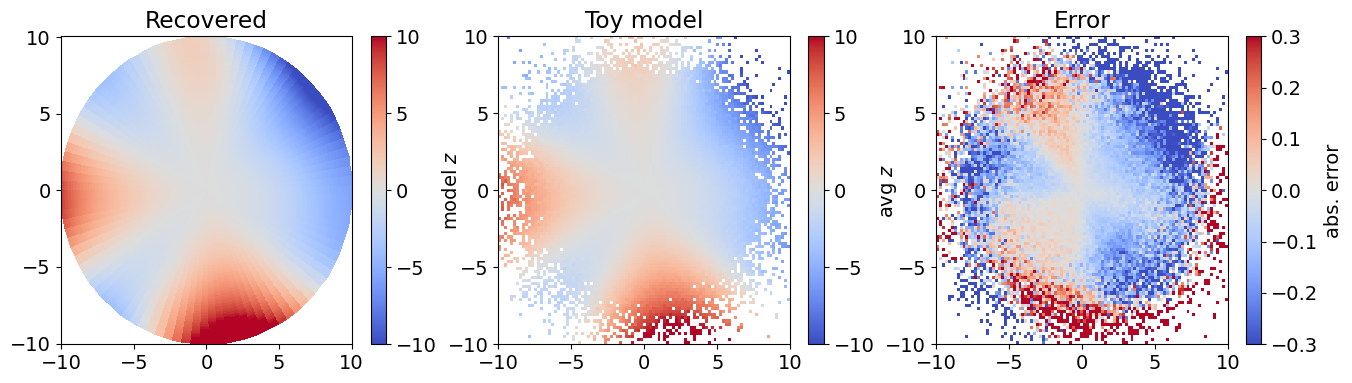

In [6]:
#############################
# Get the recovered z-profile
# First set up bins
R_grid,Theta_grid = np.meshgrid(np.linspace(0,10,100),np.linspace(0,2*np.pi,100))
X_grid,Y_grid = R_grid*np.cos(Theta_grid), R_grid*np.sin(Theta_grid)
grid_pos = np.array([X_grid.flatten(),Y_grid.flatten()]).T

# Now get the recovered Z-position along these bins
z_recov = warpModel.reconstruct_disk(grid_pos).reshape((100,100))

# And plot these

fig,axes = plt.subplots(1,3,figsize=(16,4))

im = axes[0].pcolormesh(X_grid,Y_grid,(z_recov.reshape(X_grid.shape)),cmap='coolwarm',vmax=10,vmin=-10)
plt.colorbar(im,ax=axes[0],label=r'model $z$')

im = axes[1].pcolormesh(x_bin,x_bin,avg_offset.T,cmap='coolwarm',vmax=10,vmin=-10)
plt.colorbar(im,ax=axes[1],label=r'avg $z$')

#########
x_bin_center = x_bin[:-1] + (x_bin[1]-x_bin[0])
X,Y = np.meshgrid(x_bin_center,x_bin_center)
pts = np.array([X.flatten(),Y.flatten()]).T

model_error = warpModel.reconstruct_disk(pts).reshape(X.shape) - avg_offset.T

im = axes[2].pcolormesh(x_bin,x_bin,model_error,cmap='coolwarm',vmin=-.3,vmax=.3)
plt.colorbar(im,label='abs. error');

axes[0].set_title('Recovered')
axes[1].set_title('Toy model')
axes[2].set_title('Error')

## Apply to TNG subhaloID = 533060

In [7]:
# Load. Note that this galaxy has already been centered in both position and velocity
cutout = np.load('SubhaloID_533060_snapshot_99_cutout.npy',allow_pickle=True).item()

# Rotate into plane of inner disk
r = np.sqrt(np.sum(cutout['PartType4']['Coordinates']**2,axis=1))
in_3kpc = r<=3

L_parts = cutout['PartType4']['Masses'].reshape(-1,1) * np.cross(cutout['PartType4']['Coordinates'],
                                                      cutout['PartType4']['Velocities'])
L_spec_3kpc = (np.sum(L_parts[in_3kpc],axis=0) / np.sum(cutout['PartType4']['Masses'][in_3kpc]).reshape(-1,1)).reshape(3)


e3 = L_spec_3kpc / np.sqrt(np.sum(L_spec_3kpc**2))
e1 = np.cross(np.array([0,1,0]),e3)
e1 = e1 / np.sqrt(np.sum(e1**2))
e2 = np.cross(e3,e1)

Rmat = np.array([e1,e2,e3]).T

# Rotate
for pt in [4,1,0]:
    cutout['PartType%d'%pt]['Coordinates'] = Rmat.T.dot(cutout['PartType%d'%pt]['Coordinates'].T).T
    cutout['PartType%d'%pt]['Velocities'] = Rmat.T.dot(cutout['PartType%d'%pt]['Velocities'].T).T

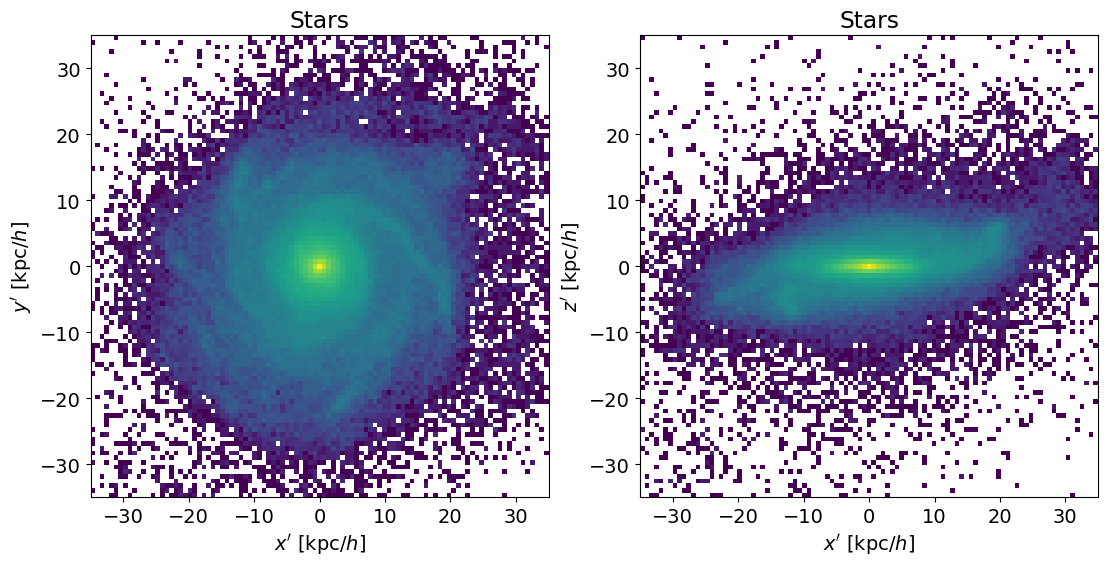

In [8]:
# Visualize
fig,axes = plt.subplots(1,2,figsize=(13,6))
bins = np.linspace(-35,35,100)
hist,_,_ = np.histogram2d(cutout['PartType4']['Coordinates'][:,0],
                          cutout['PartType4']['Coordinates'][:,2],bins=bins)

axes[1].pcolormesh(bins,bins,np.log10(hist.T))
axes[1].set_xlabel(r"$x'$ [kpc/$h$]")
axes[1].set_ylabel(r"$z'$ [kpc/$h$]");
axes[1].set_title('Stars')

hist,_,_ = np.histogram2d(cutout['PartType4']['Coordinates'][:,0],
                          cutout['PartType4']['Coordinates'][:,1],bins=bins)

axes[0].pcolormesh(bins,bins,np.log10(hist.T))
axes[0].set_xlabel(r"$x'$ [kpc/$h$]")
axes[0].set_ylabel(r"$y'$ [kpc/$h$]");
axes[0].set_title('Stars');

## Examine density structure to make good bin choice

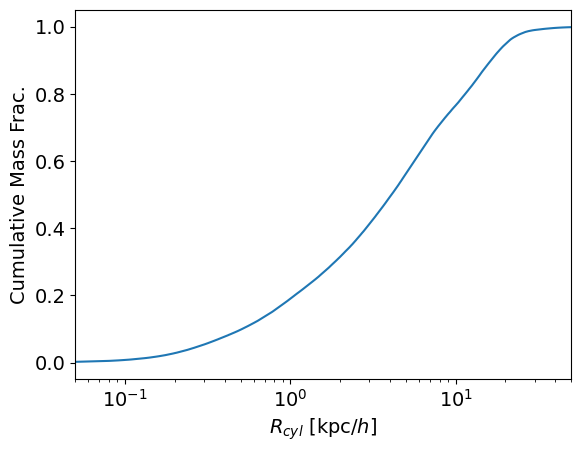

In [9]:
# Make cumulative mass histogram

Rcyl = np.sqrt(cutout['PartType4']['Coordinates'][:,0]**2 + \
            cutout['PartType4']['Coordinates'][:,1]**2)

sortInds = np.argsort(Rcyl)
cumMassFrac = np.cumsum(cutout['PartType4']['Masses'][sortInds])/np.sum(cutout['PartType4']['Masses'])

plt.plot(Rcyl[sortInds],cumMassFrac)
plt.xscale('log')
plt.xlim(5e-2,5e1)
plt.xlabel(r'$R_{cyl}$ [kpc/$h$]')
plt.ylabel('Cumulative Mass Frac.');

## Log-spaced bins in the range ~ 0.1 - 20 is best, but we can push the outer limit to 30. Now perform the expansion

In [14]:
# We see that the curve is ~ linear in log space from 1 to ~25, choose this range
logBins = np.logspace(0,np.log10(30),25)
mmax = 12
# Decompose the disk 
warpModel = decomposeDisk(cutout['PartType4']['Coordinates'],
                          cutout['PartType4']['Masses'],logBins,mmax=mmax)

## Plot coefficients

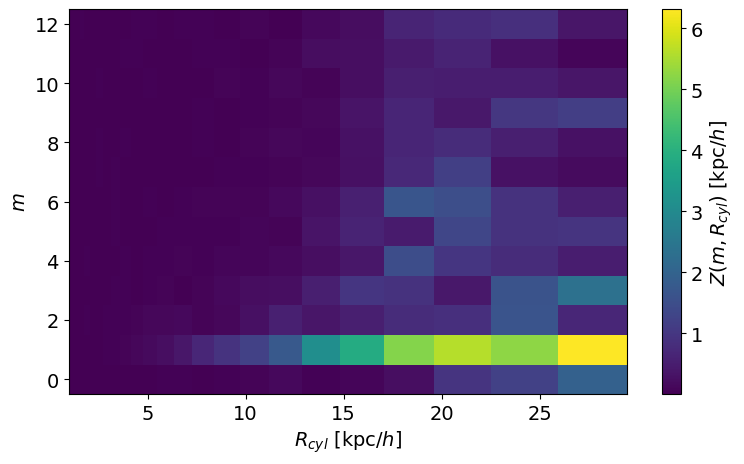

In [15]:
# Get the coefficients
plt.figure(figsize=(9,5))
im = plt.pcolormesh(warpModel.bin_centers,np.arange(mmax+1),warpModel.z_m_R_mag.T)
plt.ylabel(r'$m$')
plt.xlabel(r'$R_{cyl}$ [kpc/$h$]')
plt.colorbar(im,label=r'$Z(m,R_{cyl})$ [kpc/$h$]');

## And recover the Z-profile

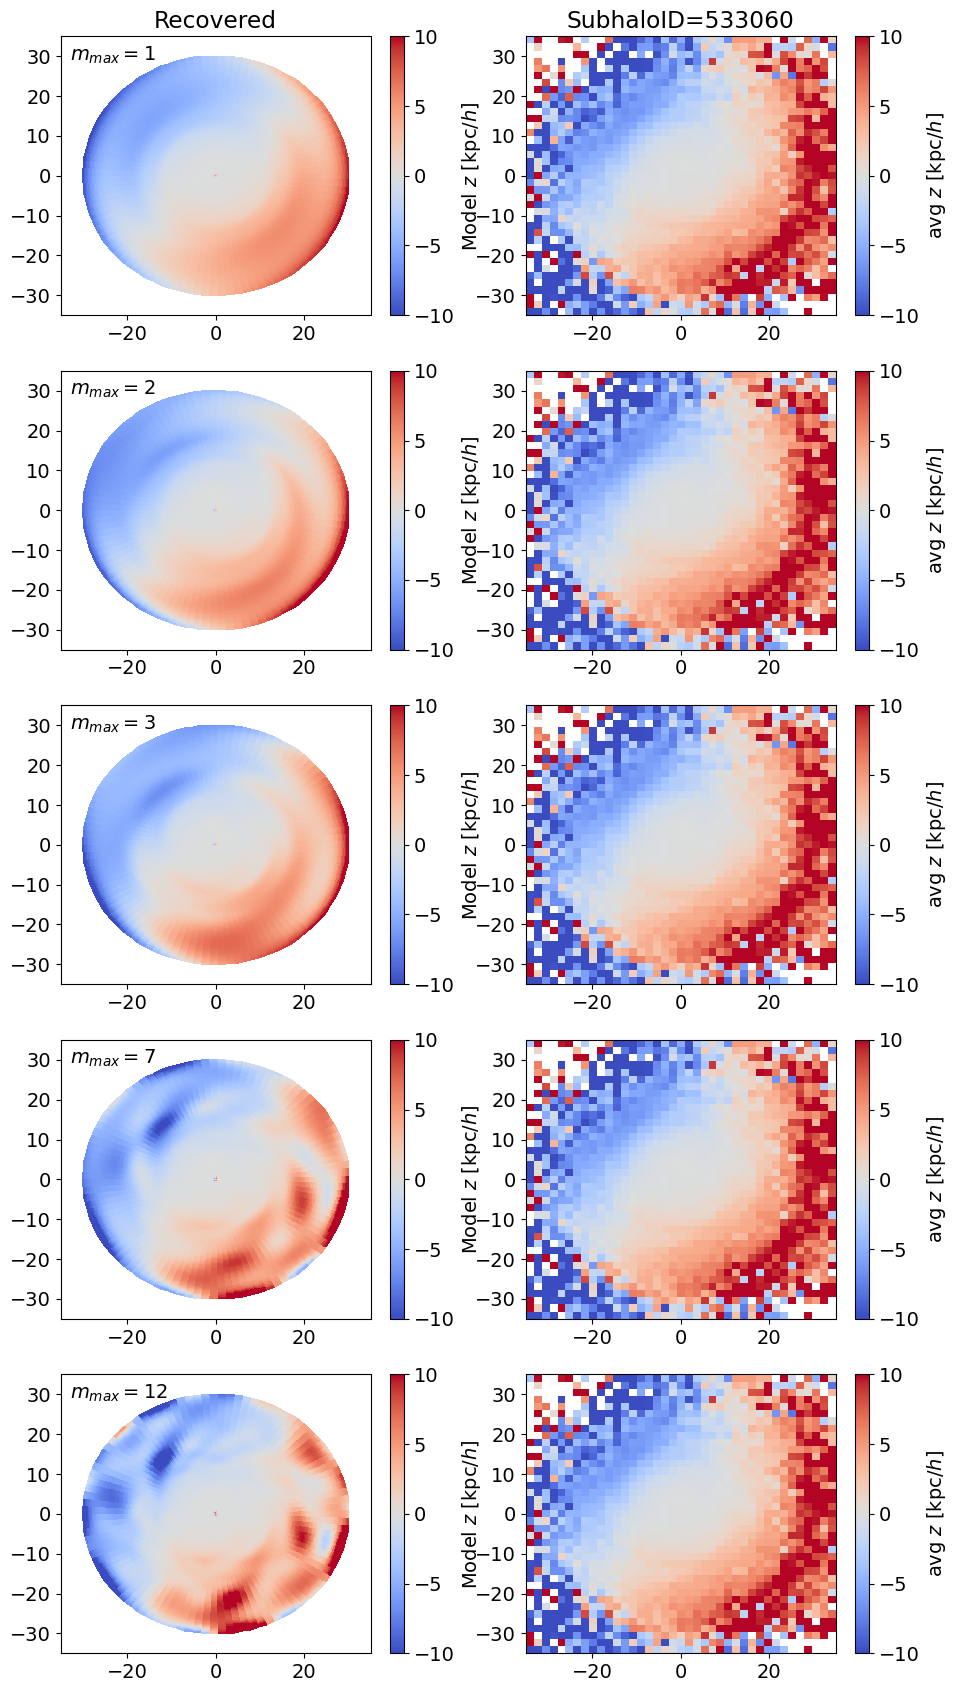

In [16]:
# Create a reconstruction of the disk
R_grid,Theta_grid = np.meshgrid(np.linspace(0,30,100),np.linspace(0,2*np.pi,100))
X_grid,Y_grid = R_grid*np.cos(Theta_grid), R_grid*np.sin(Theta_grid)
sample_pts = np.array([X_grid.flatten(),Y_grid.flatten()]).T

fig,axes = plt.subplots(5,2,figsize=(11,21))

mmax_recon = [1,2,3,7,12]
for i in range(5):
    
    z_recov = warpModel.reconstruct_disk(sample_pts,m_inds=np.arange(mmax_recon[i]+1)).reshape((100,100))

    im = axes[i,0].pcolormesh(X_grid,Y_grid,(z_recov),cmap='coolwarm',vmin=-10,vmax=10)
    plt.colorbar(im,ax=axes[i,0],label=r'Model $z$ [kpc/$h$]')

    ##### 
    # for subhalo
    x_bin = np.linspace(-35,35,40)
    hist,_,_ = np.histogram2d(cutout['PartType4']['Coordinates'][:,0],
                              cutout['PartType4']['Coordinates'][:,1],bins=x_bin,
                              weights = (cutout['PartType4']['Coordinates'][:,2]*\
                                         cutout['PartType4']['Masses']))

    norm,_,_ = np.histogram2d(cutout['PartType4']['Coordinates'][:,0],
                              cutout['PartType4']['Coordinates'][:,1],bins=x_bin,
                              weights = cutout['PartType4']['Masses'])
    avg_offset = hist/norm

    im = axes[i,1].pcolormesh(x_bin,x_bin,avg_offset.T,cmap='coolwarm',vmax=10,vmin=-10)
    plt.colorbar(im,ax=axes[i,1],label=r'avg $z$ [kpc/$h$]')
    
    axes[i,0].text(-33,29,r'$m_{max}=%d$'%mmax_recon[i])
    axes[i,0].set_xlim(-35,35)
    axes[i,0].set_ylim(-35,35)
    axes[i,1].set_xlim(-35,35)
    axes[i,1].set_ylim(-35,35)

axes[0,0].set_title('Recovered')
axes[0,1].set_title('SubhaloID=533060');

## We can see that adding additional terms beyond $m = 3$ seems to just add noise, so we can limit the expansion to this order. Probably $m=1$ is adequate

## To determine something like a warp angle, we look at the slope of the $m=1$ term over radius:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


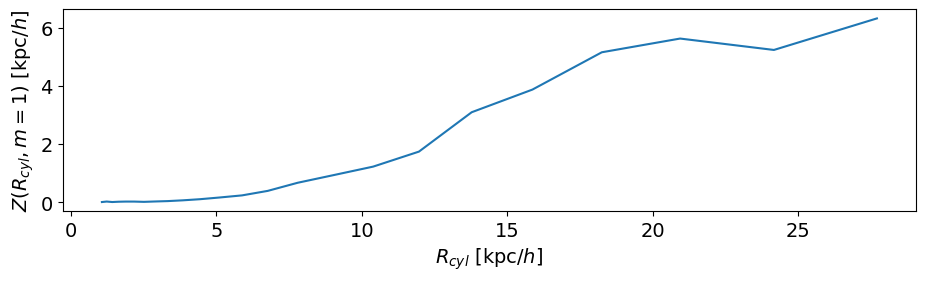

In [17]:
# Get the coefficients
fig,ax = plt.subplots(1,1,figsize=(11,6))
ax.set_aspect('equal')

#plt.plot(x_test,0.5*x_test-4,color='k',ls=':',lw=3,label=r'Angle: $30^\circ$')
plt.plot(warpModel.bin_centers,warpModel.z_m_R_mag[:,1])

x_test = np.array([10,20])
plt.legend(frameon=False)
plt.ylabel(r'$Z(R_{cyl},m=1)$ [kpc/$h$]')
plt.xlabel(r'$R_{cyl}$ [kpc/$h$]');


## This could be made more sophisticated by either fitting a power law to the full profile or line to the outer profile to get the slope in the warped region